# Yammer Challenge

The overall goal of this challenge is to find the reason for a drop in engagement on Yammer that occured in August 2014.

Ultimately, it looks like the drop off in engagement is associated with fewer weekly digests being sent and therefore fewer users going to the home page of the site. It is recommended that the weekly digest team get their head in the game.

## Getting Oriented

Some of the possible reasons for the drop in engagement may include:

- A big company just left the site, taking all of their employees with them
- Some functionality is down, so users who rely on that are no longer able to use it
- Or other stuff that I totally wrote down before I looked at the data. Totally.
- Like maybe Yammer stopped prompting people to come to the site and login.


## Load in the Data

The yammer data is stored in 4 different csv files. I'm just going to load each one into a pandas dataframe. If that fails, I may play with some SQL.

In [1]:
#import packages
import pandas as pd

In [2]:
users = pd.read_csv('yammer_users.csv', low_memory=False)
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [3]:
events = pd.read_csv('yammer_events.csv', low_memory=False)
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [4]:
emails = pd.read_csv('yammer_emails.csv', low_memory=False)
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


In [5]:
rollup_periods = pd.read_csv('dimension_rollup_periods.csv', low_memory=False)
rollup_periods.head()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
0,1.0,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-01 08:00:00,2013-01-02 08:00:00
1,1.0,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-02 08:00:00,2013-01-03 08:00:00
2,1.0,2013-01-03 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-03 08:00:00,2013-01-04 08:00:00
3,1.0,2013-01-04 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-04 08:00:00,2013-01-05 08:00:00
4,1.0,2013-01-05 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-05 08:00:00,2013-01-06 08:00:00


## Explore the data

The goal is to replicate the plot shown in the prompt and also to plot up some key factors versus measures of engagement.

In [8]:
#import packages
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')
print(alt.renderers.active)

notebook


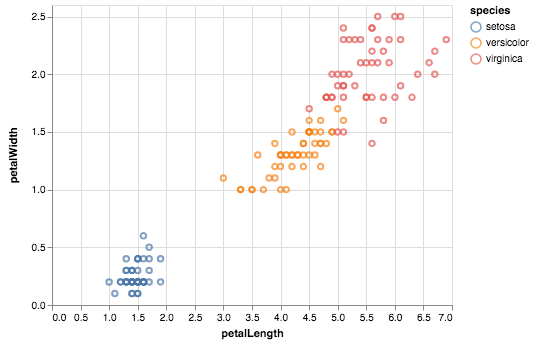

In [9]:
from vega_datasets import data

iris = data.iris()

alt.Chart(iris).mark_point().encode(
    x='petalLength',
    y='petalWidth',
    color='species'
)

In [10]:
emails.shape

(90389, 4)

In [11]:
users.shape

(19066, 6)

In [12]:
events.shape

(340832, 7)

In [13]:
emails.isna().sum()

user_id        0
occurred_at    0
action         0
user_type      0
dtype: int64

In [14]:
users.isna().sum()
#all of the na values are concentrated in one columns

user_id            0
created_at         0
company_id         0
language           0
activated_at    9685
state              0
dtype: int64

In [15]:
events.isna().sum()
#all of the na values are concentrated in one column
#and that column isn't even in the list of column descriptions

user_id            0
occurred_at        0
event_type         0
event_name         0
location           0
device             0
user_type      15577
dtype: int64

In [17]:
#drop the columns with na values
events = events.drop(columns='user_type')
users = users.drop(columns='activated_at')
events.head()

   user_id          occurred_at  event_type    event_name location  \
0  10522.0  2014-05-02 11:02:39  engagement         login    Japan   
1  10522.0  2014-05-02 11:02:53  engagement     home_page    Japan   
2  10522.0  2014-05-02 11:03:28  engagement  like_message    Japan   
3  10522.0  2014-05-02 11:04:09  engagement    view_inbox    Japan   
4  10522.0  2014-05-02 11:03:16  engagement    search_run    Japan   

                   device  
0  dell inspiron notebook  
1  dell inspiron notebook  
2  dell inspiron notebook  
3  dell inspiron notebook  
4  dell inspiron notebook  


In [21]:
#what companies do people come from
company_counts = users.groupby('company_id').agg({'user_id':'count'}).rename(columns={'user_id':'user_count'})
company_counts.head()

,user_count
company_id,
1.0,1036
2.0,477
3.0,307
4.0,220
5.0,172


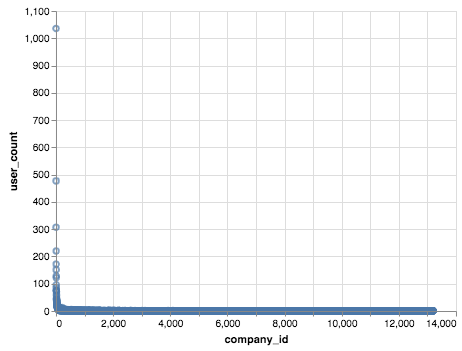

In [31]:
#certainly it appears that users are concentrated from just a few of the companies
alt.Chart(company_counts.reset_index()).mark_point().encode(
    x='company_id:Q',
    y='user_count:Q'
)

In [34]:
#set columns that need to be datetimes to datetimes
events['occurred_at'] = pd.to_datetime(events['occurred_at'])

In [35]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook


In [37]:
#Keep only engagement events
print(events.event_type.unique())
events = events.loc[events['event_type']=='engagement']
print(events.event_type.unique())

['engagement' 'signup_flow']
['engagement']


In [52]:
#aggregate by week
weekly_events_by_user = events.groupby(['user_id','event_name','location','device', 
                                    pd.Grouper(key='occurred_at', freq='W-MON')]).agg({'event_name':'count'}).rename(columns = {'event_name':'event_count'})

In [53]:
weekly_events_by_user.head()

event_count
user_id event_name location device                occurred_at             
4.0     home_page  India    dell inspiron desktop 2014-06-16             5
                                                  2014-06-30             1
                            lenovo thinkpad       2014-05-19             1
                                                  2014-06-02             6
                                                  2014-06-09             1

In [56]:
weekly_events_by_user=weekly_events_by_user.reset_index()
weekly_events_by_user.head()

,user_id,event_name,location,device,occurred_at,event_count
0,4.0,home_page,India,dell inspiron desktop,2014-06-16,5
1,4.0,home_page,India,dell inspiron desktop,2014-06-30,1
2,4.0,home_page,India,lenovo thinkpad,2014-05-19,1
3,4.0,home_page,India,lenovo thinkpad,2014-06-02,6
4,4.0,home_page,India,lenovo thinkpad,2014-06-09,1


In [73]:
weekly_summary = weekly_events_by_user.groupby('occurred_at').agg({'user_id':'count',
                                                                 'event_count':'sum'}).rename({
    'user_id':'id_count',
    'event_count':'event_sum'}).reset_index().sort_values('occurred_at')

In [74]:
weekly_summary.head()

,occurred_at,user_id,event_count
0,2014-05-05,4862,11292
1,2014-05-12,6991,17326
2,2014-05-19,7282,17420
3,2014-05-26,7331,17738
4,2014-06-02,7204,17277


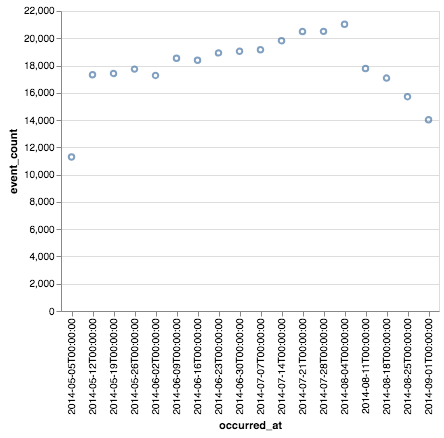

In [77]:
alt.Chart(weekly_summary).mark_point().encode(
    x='occurred_at:O',
    y='event_count:Q',
)

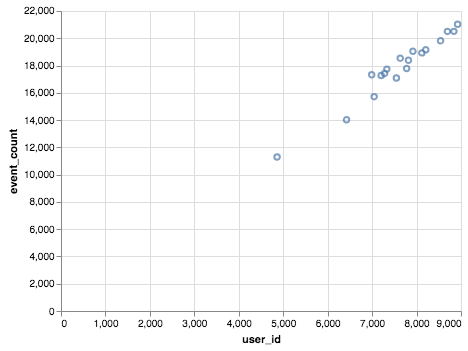

In [78]:
#I would expect this to correlate strongly
alt.Chart(weekly_summary).mark_point().encode(
    x='user_id:Q',
    y='event_count:Q',
)

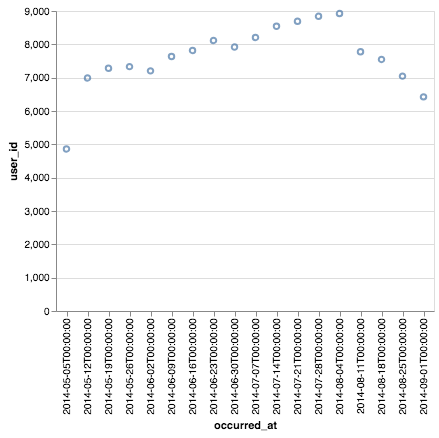

In [80]:
#the drop off in events occurs with a related drop off in users
#this gives some initial support for the hypothesis that a large company may have transitioned away from the platform
alt.Chart(weekly_summary).mark_point().encode(
    x='occurred_at:O',
    y='user_id:Q',
)

In [81]:
#join weekly activity and user info table
weekly_events_user_info = weekly_events_by_user.join(users.set_index('user_id'), on='user_id')
weekly_events_user_info.head()

,user_id,event_name,location,device,occurred_at,event_count,created_at,company_id,language,state
0,4.0,home_page,India,dell inspiron desktop,2014-06-16,5,2013-01-01 14:37:51,5110.0,indian,active
1,4.0,home_page,India,dell inspiron desktop,2014-06-30,1,2013-01-01 14:37:51,5110.0,indian,active
2,4.0,home_page,India,lenovo thinkpad,2014-05-19,1,2013-01-01 14:37:51,5110.0,indian,active
3,4.0,home_page,India,lenovo thinkpad,2014-06-02,6,2013-01-01 14:37:51,5110.0,indian,active
4,4.0,home_page,India,lenovo thinkpad,2014-06-09,1,2013-01-01 14:37:51,5110.0,indian,active


In [82]:
weekly_events_user_info=weekly_events_user_info.drop(columns='created_at')
weekly_events_user_info.shape

(137157, 9)

## Hypothesis Testing

Now that we've done some initial exploration and cleaning, let's test some hypotheses.

### Hypothesis 1: A major company dumped us

To test this we'll

- Find the five or ten biggest companies on the site
- Plot activity over time by company id to see if they all drop off equally or just one

In [85]:
company_ranks = users.groupby('company_id').agg({'user_id':'count'}).rename(columns={'user_id':'user_count'}).reset_index().sort_values('user_count',ascending=False)
company_ranks[0:10]

,company_id,user_count
0,1.0,1036
1,2.0,477
2,3.0,307
3,4.0,220
4,5.0,172
5,6.0,151
7,8.0,129
6,7.0,122
8,9.0,96
9,10.0,86


In [ ]:
#So the biggest ones also have the lowest id numbers. How handy

In [88]:
weekly_events_user_info.columns

Index(['user_id', 'event_name', 'location', 'device', 'occurred_at',
       'event_count', 'company_id', 'language', 'state'],
      dtype='object')

In [92]:
events_by_company = weekly_events_user_info.groupby(['company_id','occurred_at']).agg({'event_count':'sum'}).reset_index().sort_values('company_id')

In [94]:
events_by_company.head(10)

,company_id,occurred_at,event_count
0,1.0,2014-05-05,740
17,1.0,2014-09-01,788
16,1.0,2014-08-25,783
15,1.0,2014-08-18,991
14,1.0,2014-08-11,1131
13,1.0,2014-08-04,1208
11,1.0,2014-07-21,1076
10,1.0,2014-07-14,1092
9,1.0,2014-07-07,1105
12,1.0,2014-07-28,1258


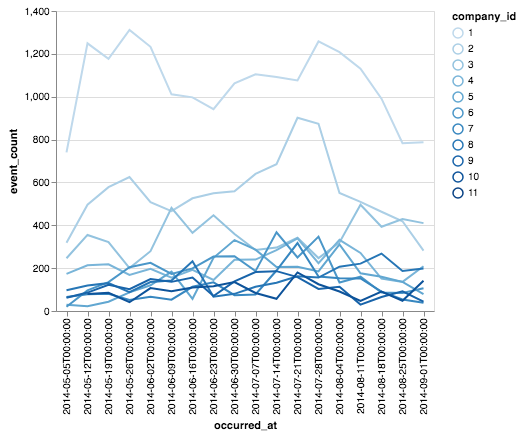

In [97]:
#plot the events per week for the top 11 companies.
#it looks like there has been a drop off in activity for the top two companies
alt.Chart(events_by_company.head(180)).mark_line().encode(
    x='occurred_at:O',
    y='event_count:Q',
    color = 'company_id:O'
)

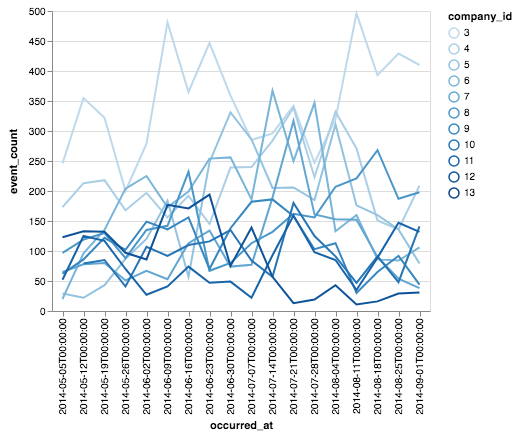

In [98]:
#Figure out whether the activity has been consistent for the other companies
events_by_small_company = events_by_company.loc[events_by_company['company_id']>2]
alt.Chart(events_by_small_company.head(180)).mark_line().encode(
    x='occurred_at:O',
    y='event_count:Q',
    color = 'company_id:O'
)

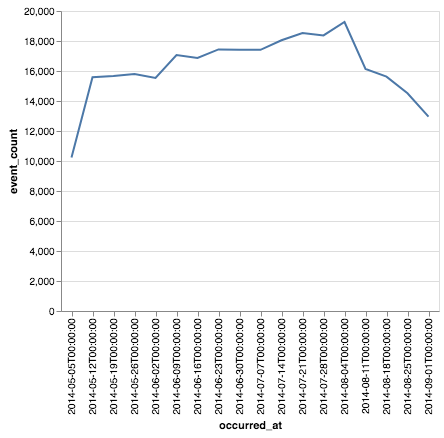

In [100]:
total_small = events_by_small_company.groupby('occurred_at').agg({'event_count':'sum'}).reset_index()
alt.Chart(total_small).mark_line().encode(
    x='occurred_at:O',
    y='event_count:Q',
)
#Nope, there's still the same dropoff in activity amongst the small companies.
#It's not just an issue with the biggest client.

### Hypothesis 2: Some key functionality isn't working

Perhaps the drop off is associated with a particular device type, country, or event_type. This could indicate a bug that must be fixed.

In [101]:
weekly_events_user_info.head()

,user_id,event_name,location,device,occurred_at,event_count,company_id,language,state
0,4.0,home_page,India,dell inspiron desktop,2014-06-16,5,5110.0,indian,active
1,4.0,home_page,India,dell inspiron desktop,2014-06-30,1,5110.0,indian,active
2,4.0,home_page,India,lenovo thinkpad,2014-05-19,1,5110.0,indian,active
3,4.0,home_page,India,lenovo thinkpad,2014-06-02,6,5110.0,indian,active
4,4.0,home_page,India,lenovo thinkpad,2014-06-09,1,5110.0,indian,active


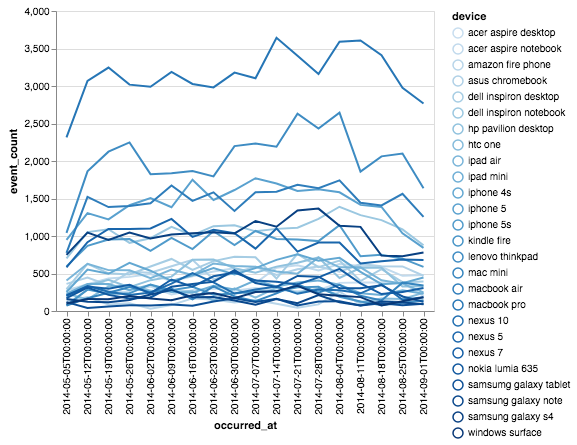

In [105]:
#check if the drop off is different for different devices
by_device = weekly_events_user_info.groupby(['device','occurred_at']).agg({'event_count':'sum'}).reset_index()
alt.Chart(by_device).mark_line().encode(
    x='occurred_at:O',
    y='event_count:Q',
    color = 'device:O')
#No. It looks pretty accross the board.

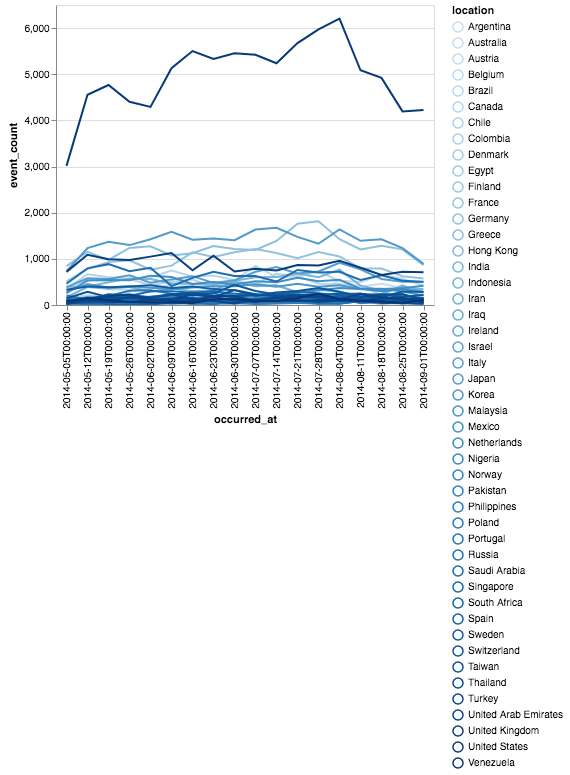

In [106]:
#check if its associated with the country
by_device = weekly_events_user_info.groupby(['location','occurred_at']).agg({'event_count':'sum'}).reset_index()
alt.Chart(by_device).mark_line().encode(
    x='occurred_at:O',
    y='event_count:Q',
    color = 'location:O')
#A lot of drop off from the US. Looks like it's not a translation issue.

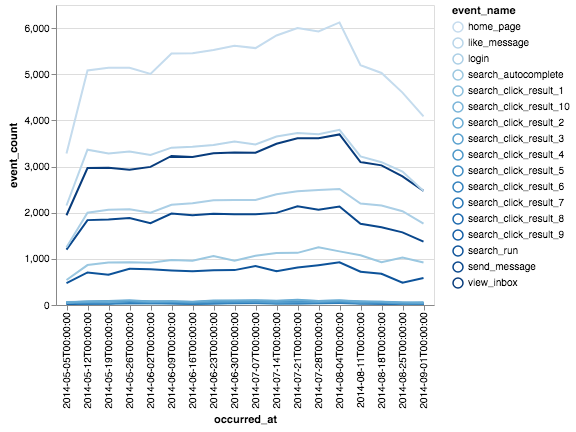

In [109]:
by_device = weekly_events_user_info.groupby(['event_name','occurred_at']).agg({'event_count':'sum'}).reset_index().sort_values('event_count')
alt.Chart(by_device).mark_line().encode(
    x='occurred_at:O',
    y='event_count:Q',
    color = 'event_name:O')
#Now we're getting somewhere. It look like a lot of the drop off is associated with the home page.
#People just aren't checking the website at all.

### Hypothesis 4: The drop off in events is correlated with a drop off in notifications

To get at this information we'll need to play with the email data.

In [110]:
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


In [116]:
#emails by week
emails['occurred_at'] = pd.to_datetime(emails['occurred_at'])
weekly_emails_by_user = emails.groupby(['user_id','action',
                                    pd.Grouper(key='occurred_at', freq='W-MON')]).agg({'user_type':'count'})

In [117]:
weekly_emails_by_user.head()

user_type
user_id action     occurred_at           
0.0     email_open 2014-06-09           1
                   2014-06-16           1
                   2014-06-23           1
                   2014-08-04           1
                   2014-08-25           1

In [119]:
weekly_emails_by_user= weekly_emails_by_user.rename(columns={'user_type':'action_count'}).reset_index()

In [120]:
weekly_emails_by_user.head()

,user_id,action,occurred_at,action_count
0,0.0,email_open,2014-06-09,1
1,0.0,email_open,2014-06-16,1
2,0.0,email_open,2014-06-23,1
3,0.0,email_open,2014-08-04,1
4,0.0,email_open,2014-08-25,1


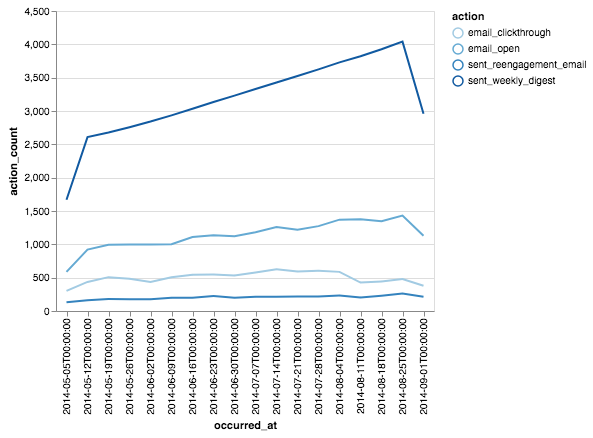

In [128]:
#Is there a particular action that may be responsible for this
by_action = weekly_emails_by_user.groupby(['action','occurred_at']).agg({'action_count':'sum'}).reset_index()
alt.Chart(by_action).mark_line().encode(
    x='occurred_at:O',
    y='action_count:Q',
    color = 'action:O')
#Wow. The weekly digest does not appear to be going out as often.

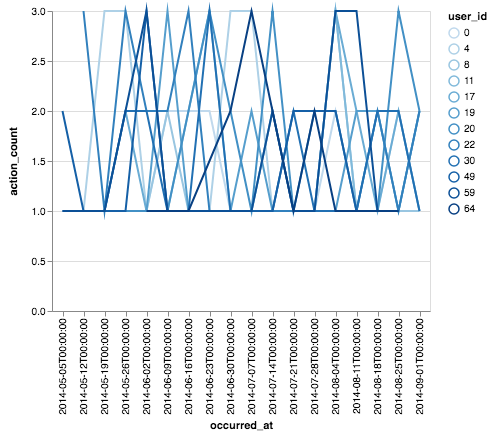

In [132]:
#check if by user is meaningful at all
by_user = weekly_emails_by_user.groupby(['user_id','occurred_at']).agg({'action_count':'sum'}).reset_index().sort_values('user_id')
alt.Chart(by_user.head(200)).mark_line().encode(
    x='occurred_at:O',
    y='action_count:Q',
    color = 'user_id:O')
#Nope.

In [ ]:
#So it looks like the drop off is associated with fewer weekly digests going out

#It is uninteresting to look at the user email data
#However, it would be possible to tie the user ids together for the email prompts
#And the engagements to show if the digest is missing some people more than others
#That might be an interesting thing to do if I had more time